In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [4]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import seaborn as sns
import cv2
from pathlib import Path
import os
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [6]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Priority', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'General Danger(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Double_Curve', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Ice_Snow', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

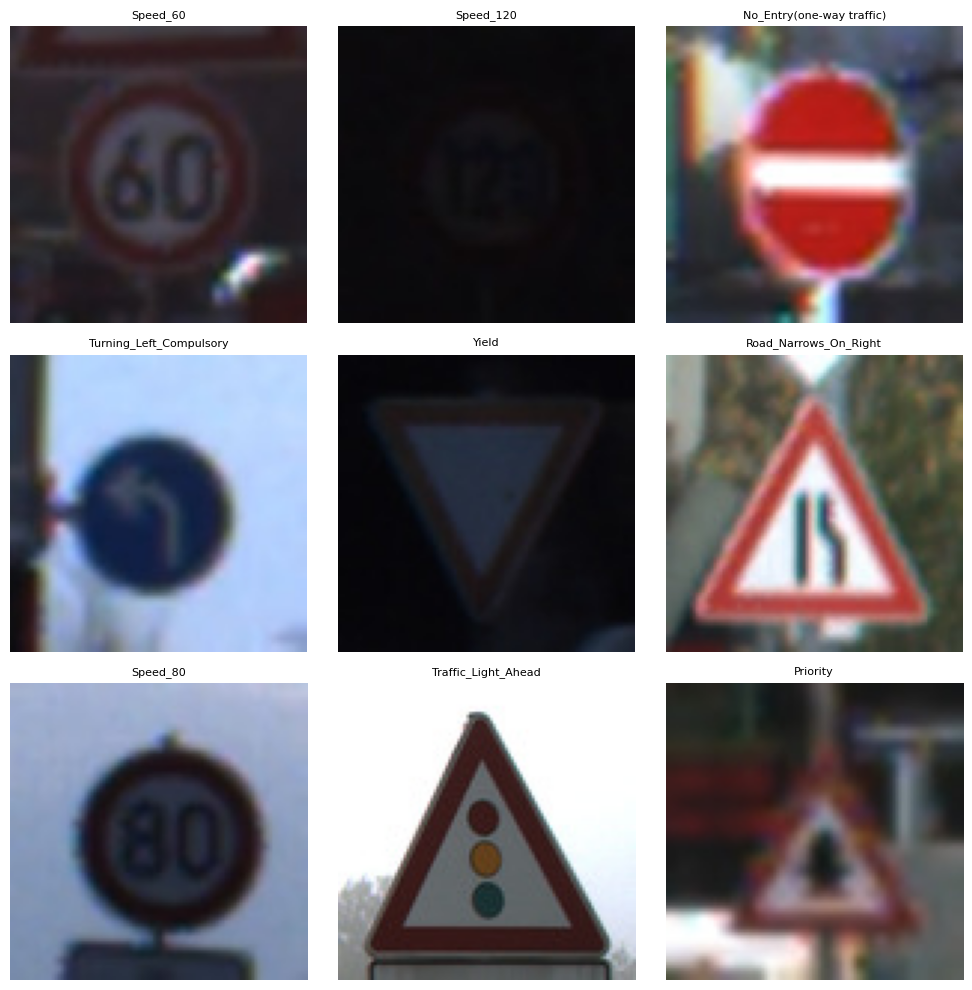

In [9]:
#Map labels to signs
import matplotlib.pyplot as plt

# target_names list
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
    'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
    'Overtakeing_Prohibited_Trucks', 'Priority', 'Priority_Road_Ahead', 'Yield', 'STOP',
    'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'General Danger(!)', 'Left_Curve_Ahead',
    'Right_Curve_Ahead', 'Double_Curve', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
    'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
    'Ice_Snow', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
    'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
    'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

plt.figure(figsize=(10, 10))

# Get one batch from the generator
images, labels = next(train_generator)
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))

    # Map numeric label to its corresponding name
    label_index = int(labels[i])
    label_name = target_names[label_index]

    plt.title(label_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
#Mount google drive to enalble checkpoint saving
from google.colab import drive

# This command opens a new tab/window for authentication
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Build a model...
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, callbacks
from google.colab import drive
import os

# ==============================================================================
# 1. SETUP & CONFIGURATION
# ==============================================================================
# Mount Google Drive to save your best model permanently
drive.mount('/content/drive')

# Configuration
BATCH_SIZE = 32
IMG_SIZE = (100, 100) # Matching the size from your original image
DATA_DIR = '/content/training/' # The location created by the download/unzip cell
CHECKPOINT_PATH = '/content/drive/MyDrive/my_best_traffic_model.keras' # Save location

# ==============================================================================
# 2. DATA LOADING (Modern Method)
# ==============================================================================
print("Loading Training Data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int' # Returns integer labels (0, 1, 2...)
)

print("Loading Validation Data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Performance Optimization: Keep data in memory to speed up training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# ==============================================================================
# 3. AUGMENTATION & MODEL ARCHITECTURE
# ==============================================================================
# def create_augmentation_layer():
#     return keras.Sequential([
#         layers.RandomRotation(factor=0.042, fill_mode='nearest'),
#         layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='nearest'),
#         layers.RandomZoom(height_factor=(-0.2, 0.2), fill_mode='nearest'),
#         layers.RandomBrightness(factor=0.2),
#         layers.RandomContrast(factor=0.2),
#     ], name='data_augmentation')

model = models.Sequential([
    layers.Input(shape=(100, 100, 3)),

    # 1. Normalize pixel values from 0-255 to 0-1 (Crucial for convergence)
    layers.Rescaling(1./255),

    # 2. Augmentation (Only runs during training, not validation/testing)
    # create_augmentation_layer(),

    # 3. Convolutional Blocks
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 4. Classification Head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3), # Low dropout as requested
    layers.Dense(43, activation='softmax')
])

# ==============================================================================
# 4. COMPILE & TRAIN
# ==============================================================================
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_list = [
    # Save the model to Drive whenever validation accuracy improves
    callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    # Stop training if validation loss doesn't improve for 10 epochs
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]

# Run Training
EPOCHS = 50
print(f"Starting training... Model will be saved to {CHECKPOINT_PATH}")

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_list
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading Training Data...
Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Loading Validation Data...
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.
Starting training... Model will be saved to /content/drive/MyDrive/my_best_traffic_model.keras
Epoch 1/50
979/981 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3957 - loss: 2.1406
Epoch 1: val_accuracy improved from -inf to 0.96021, saving model to /content/drive/MyDrive/my_best_traffic_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.3965 - loss: 2.1379 - val_accuracy: 0.9602 - val_loss: 0.1453
Epoch 2/50
979/981 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9465 - loss: 0.1815
Epoch 2: val_accuracy improved from 0.96021 to 0.98878, saving model to /content/drive/MyDrive/my_best_traffic_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms

## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```